Code to produce plots for scaling relations. Uses the data in `../300km/output`, `../500km/output`, and `../800km/output`

To use this notebook, simply run all the cells. The last cell loops over all the results and creates the associated plots. In order to reference the model runs that do not include a thermal stable layer, change `stable_layer = True` to `stable_layer = False` in the last cell.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':'14'})
matplotlib.rc('text', usetex=False)

import os

In [35]:
def scalings(rs, rho, omega, sigma, EJ, Tmean):
    """B2 ∼ ρ * μ0 * L**(2/3) * p**(2/3)
       p = PA/(rho*V) = DO + DV ≈ (EJ*Tmean)/(rho*V)
       
       The factor of (rho*V) arises because the MAc balance in 
       https://doi.org/10.1093/gji/ggab342 (eqn 3) is derived from 
       the NS eqn divided by  rho, while the energy balance (eqn 4) is 
       derived from the kinetic energy equation without dividing by rho.
       """

    mu0    = 4.0*np.pi*1e-7 # Magnetic permeability of vacuum (H/m)   
    eta    = 1e0/(mu0*sigma)
    print('eta sigma/1e5 =', eta, sigma/1e5)
    
    prefac = 1.0
    exp_En = 1e0/3e0               # Exponent for scaling
    d      = rs                    # (convecting) outer core thickness
    Voc    = 4.0*np.pi*(rs**3)/3.0 # Outer core volume
    # P      = EJ*Tmean/(rho[0]*Voc) # Assumes constant density
    
    P = np.zeros(EJ.size)
    P[EJ>0] = EJ[EJ>0]*Tmean/(rho[0]*Voc) #Avoid negative Ej.

    Brms   = prefac * (rho[0]*mu0)**0.5 * (d**exp_En) * (P)**exp_En #RMS internal field strength

    Ro     = (P / (omega**3 * rs**2))**(4e0/9e0)                    #Rossby number
    Rm     = Ro * omega * d**2 / eta                                #Magnetic Reynolds number 
    lp     = (P / (omega**3 * rs**2))**(1e0/9e0)   * rs             #l_perp

    # for j, jj in enumerate(EJ):
    #     if EJ[j] < 0:
    #         Brms[j] = 0.0
    #         Ro[j]   = 0.0
    #         Rm[j]   = 0.0
    #         lp[j]   = 0.0

    #print('B,EJ,P,rho,T,Rm,rs,V = ', Brms[-2], EJ[-2]/1e5, P[-2], rho[-2], Tmean, Rm[-2], rs/1e3, Voc/1e10)
            
    return Brms, Ro, Rm, lp
    

In [36]:
def plot_scalings(data, name, B, Ro, Rm, l, ignore_last_datapoint=True):
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,8))

    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.
    
    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    ax1.plot(time[:idx], B[:idx]*1000)
    ax1.set_xlabel('time [Myrs]')
    ax1.set_ylabel('Brms [mT]')
    ax2.plot(time[:idx], Rm[:idx])
    ax2.plot(time[:idx], 50*np.ones(len(Rm[:idx])))
    ax2.set_xlabel('time [Myrs]')
    ax2.set_ylabel('$Rm$')   

    ax3.plot(time[:idx], Ro[:idx])
    ax3.set_xlabel('time [Myrs]')
    ax3.set_ylabel('$Ro$')
    ax3.set_yscale('log')
    ax4.plot(time[:idx], l[:idx]/1e3)
    ax4.set_xlabel('time [Myrs]')
    ax4.set_ylabel('$l$ (km)')
    
    fig.savefig(name+"_scaling.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig)   

In [37]:
def plot_single_ts(data, name, field, figure=None, ax=None, ignore_last_datapoint=True):
    
    if figure == None:
        fig, ax = plt.subplots(figsize=(16,6))

    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.
    variable = data['core'][field]  

    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    #plt.xlim([0,10])
    ax.plot(time[:idx], variable[:idx], label=name.split('/')[-1])  #Remove any file paths from name
    ax.legend(bbox_to_anchor=(0.1, 1.05), ncol=5)
    ax.set_xlabel('time [Myrs]')
    ax.set_ylabel(field+'[km]')
    
    if figure == None:
        fig.savefig(name+"_"+field+".pdf", format='pdf',bbox_inches="tight")
        plt.close(fig)

In [38]:
def plot_Q(data, fields, name, ignore_last_datapoint=True):
    
    fig, ax = plt.subplots(figsize=(16,6))
 
    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.

    Qs   = data['core']['Qs']/1e10
    Qcmb = data['core']['Q_cmb']/1e10
    Qls  = data['core']['Ql_s']/1e10
    Qll  = data['core']['Ql_l']/1e10
    Qlb  = data['core']['Ql_b']/1e10
    Qgb  = data['core']['Qg_b']/1e10
    Qgs  = data['core']['Qg_s']/1e10
    Qgl  = data['core']['Qg_l']/1e10   
  
    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    plt.plot(time[:idx], Qs[:idx]  , 'r-' , label='Qs')
    plt.plot(time[:idx], Qcmb[:idx], 'b-' , label='Qcmb')
    plt.plot(time[:idx], Qls[:idx] , 'g-' , label='Qls')
    plt.plot(time[:idx], Qll[:idx] , 'g--', label='Qll')
    plt.xlabel('time')
    plt.ylabel('Q ($\\times 10^{10}$ W)')
    #plt.xlim([0,5])
    #plt.ylim([0.9,1.2])

    if fields == 1: # plot the small terms
        plt.plot(time[:idx], Qlb[:idx] , 'g:' , label='Qlb')
        plt.plot(time[:idx], Qgb[:idx] , 'c:' , label='Qgb')
        plt.plot(time[:idx], Qgs[:idx] , 'c-' , label='Qgs')
        plt.plot(time[:idx], Qgl[:idx] , 'c--', label='Qgl') 
        plt.legend(loc=2, ncol=2)
        fig.savefig(name+"_Q_all.pdf", format='pdf',bbox_inches="tight")
    else:
        if Qgs[idx-1] > Qgl[idx-1]:  #Index -2 since last value is when r_snow=0 and energies/entropies are not defined.
            plt.plot(time[:idx], Qgs[:idx] , 'c-' , label='Qgs')
        else:
            plt.plot(time[:idx], Qgl[:idx], 'c--', label='Qgl')    
        plt.legend(loc=2, ncol=2)
        fig.savefig(name+"_Q_red.pdf", format='pdf',bbox_inches="tight")
    
    plt.close(fig)
    

In [39]:
def plot_E(data, fields, name, ignore_last_datapoint=True):
    
    fig, ax = plt.subplots(figsize=(16,6))

    time   = data['core']['time'] / (1e6*data['parameters']['ys'])  #Convert time from seconds to Myrs.

    Es   = data['core']['Es']/1e6
    EJ   = data['core']['Ej']/1e6
    Ek   = data['core']['Ek']/1e6
    Els  = data['core']['El_s']/1e6
    Ell  = data['core']['El_l']/1e6
    Elb  = data['core']['El_b']/1e6
    Egs  = data['core']['Eg_s']/1e6
    Egl  = data['core']['Eg_l']/1e6
    Egb  = data['core']['Eg_b']/1e6

    if ignore_last_datapoint:
        idx = time.size-1
    else:
        idx = time.size

    plt.plot(time[:idx], Es[:idx]  , 'r-' , label='Es')
    plt.plot(time[:idx], EJ[:idx]  , 'b-' , label='EJ')
    plt.plot(time[:idx], Ek[:idx]  , 'k-' , label='Ek')
    plt.plot(time[:idx], Egs[:idx] , 'c-' , label='Egs')
    plt.plot(time[:idx], Egl[:idx] , 'c--', label='Egl')
    #plt.xlim([0,5])
    #plt.ylim([0.9,1.2])
    plt.xlabel('time')
    plt.ylabel('Entropy (MW / K)')
    
    if fields == 1: # plot the small terms
        plt.plot(time[:idx], Elb[:idx] , 'g:' , label='Elb')
        plt.plot(time[:idx], Egb[:idx] , 'c:' , label='Egb')
        plt.plot(time[:idx], Els[:idx] , 'g-' , label='Els')
        plt.plot(time[:idx], Ell[:idx] , 'g--', label='Ell')
        plt.legend(loc=0)
        fig.savefig(name+"_E_all.pdf", format='pdf',bbox_inches="tight")
    else:
        if Els[idx-1] > Ell[idx-1]:  
            plt.plot(time[:idx], Els[:idx] , 'g-' , label='Els')
        else:
            plt.plot(time[:idx], Ell[:idx] , 'g--', label='Ell')
        plt.legend(loc=0)
        fig.savefig(name+"_E_red.pdf", format='pdf',bbox_inches="tight")
    
    plt.close(fig)

Plotting rc=300
Failed soln at  S=5_q=1
k1, k2 =  28.56531116071569 [28.57521958]
eta sigma/1e5 = 1.2587339044611092 6.3220249541158156
k1, k2 =  28.566492289957527 [28.57521958]
eta sigma/1e5 = 1.2587339044611092 6.3220249541158156
k1, k2 =  18.054950675007785 [18.08837075]
eta sigma/1e5 = 1.875353778742647 4.2433311755876435
k1, k2 =  18.05917651956522 [18.08837075]
eta sigma/1e5 = 1.875353778742647 4.2433311755876435
k1, k2 =  18.060062254060693 [18.08837075]
eta sigma/1e5 = 1.875353778742647 4.2433311755876435
k1, k2 =  12.113895320521882 [12.15786331]
eta sigma/1e5 = 2.587652757570759 3.0752762832310445
k1, k2 =  12.113895320529071 [12.15786331]
eta sigma/1e5 = 2.587652757570759 3.0752762832310445
k1, k2 =  12.1146086644557 [12.15786331]
eta sigma/1e5 = 2.587652757570759 3.0752762832310445
Plotting rc=500
Failed soln at  S=5_q=1
k1, k2 =  28.94789050526849 [28.87220103]
eta sigma/1e5 = 1.2587339044611092 6.3220249541158156
k1, k2 =  28.951524167759487 [28.87220103]
eta sigma/1e5 =

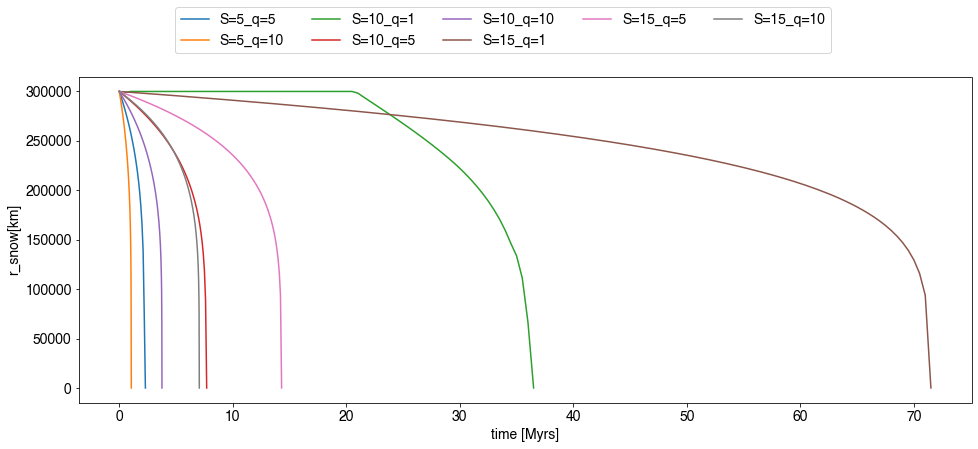

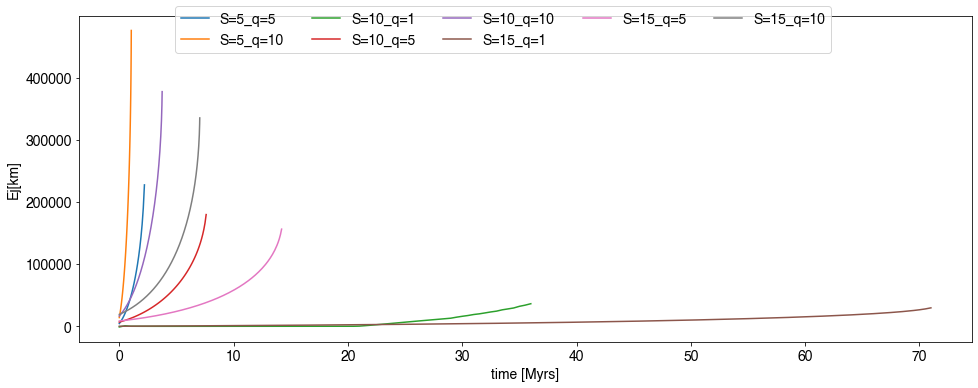

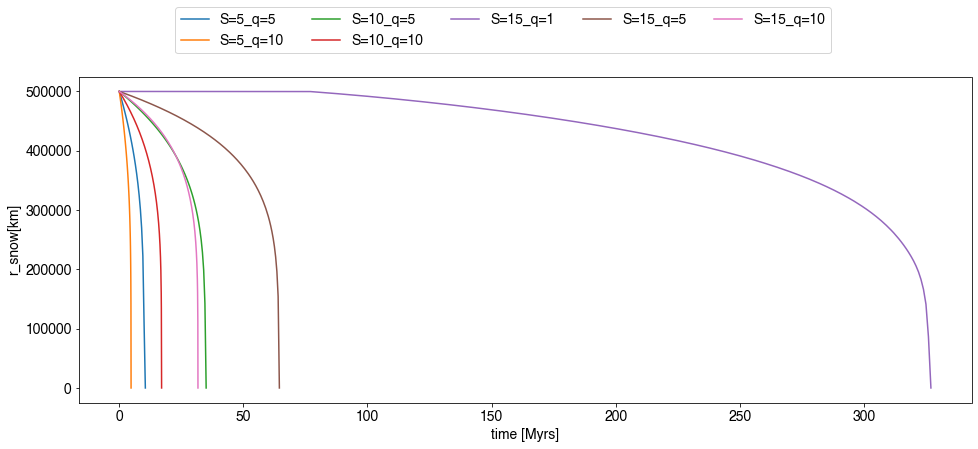

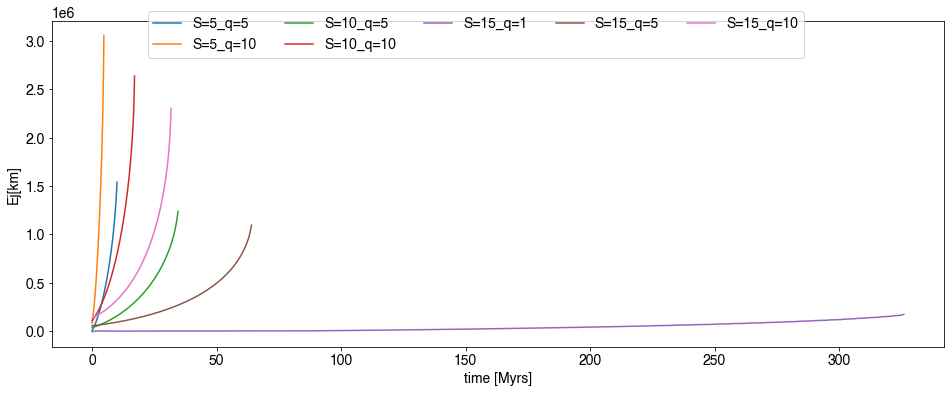

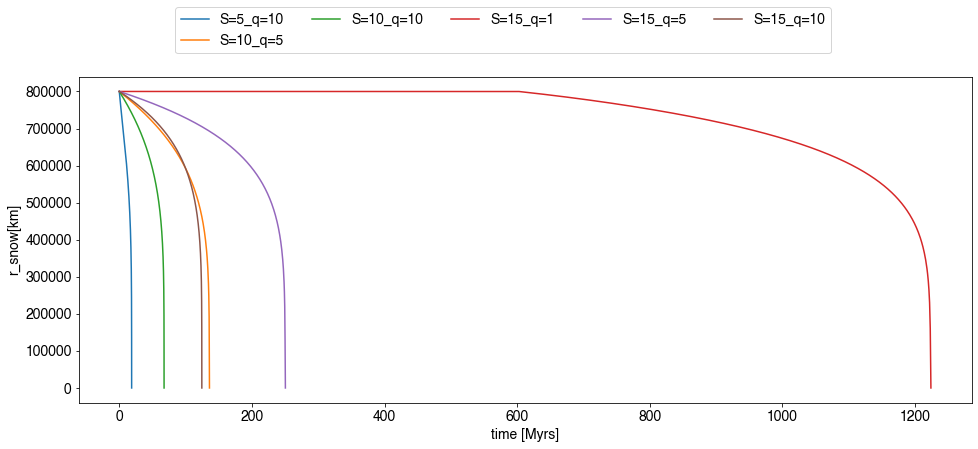

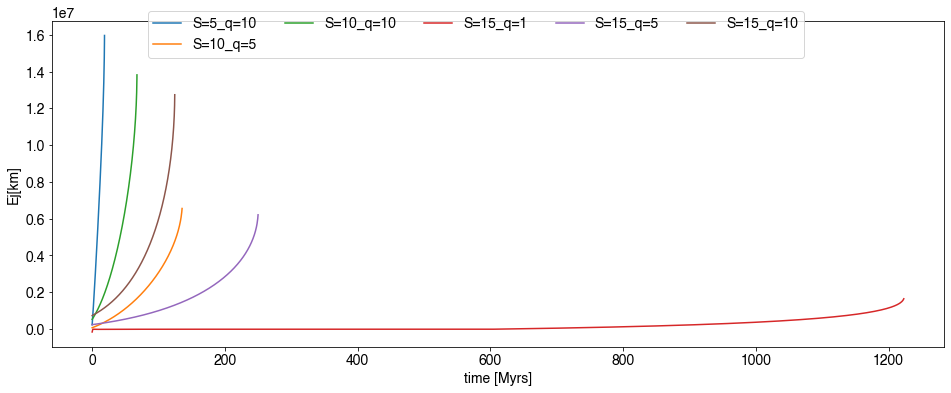

In [42]:
rc_array = [300, 500, 800]
q_cmb_array = [1, 5, 10]        #mW/m^2
S_array     = [0.05, 0.1, 0.15]

colors = ['y', 'r', 'b']
symbol = ['v', '.', '^']

stable_layer = True

# if not os.path.isdir('scaling_plots'):
#     os.mkdir('scaling_plots')

for r_cmb in rc_array:

    print(f'Plotting rc={r_cmb}')
    
    out_folder = 'scaling_plots'
    if not stable_layer:
        out_folder += '_adiabatic'

    if not os.path.isdir(out_folder): #Make top level directory for output
        os.mkdir(out_folder)

    out_folder += f'/{r_cmb}km/'        #Create folder for specific sized core.
    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)

    data = {}
    tf   = []
    EJf  = []

    ADRs  = np.zeros(len(S_array)*len(q_cmb_array))
    ADRe  = np.zeros(len(S_array)*len(q_cmb_array))

    fig1, ax1 = plt.subplots(figsize=(16,6))
    fig2, ax2 = plt.subplots(figsize=(16,6))
    fig3, ax3 = plt.subplots(figsize=(16,6))
    fig4, ax4 = plt.subplots(figsize=(16,6))
    fig5, ax5 = plt.subplots(figsize=(16,6))
    fig6, ax6 = plt.subplots(figsize=(16,6))

    omega = 2*np.pi / (28*60*60*24)

    #Begin loops
    j = 0
    for SS,S in enumerate(S_array):
        for qq,q_cmb in enumerate(q_cmb_array):

            name = f'S={S*100:.0f}_q={q_cmb:.0f}'
            file = f'../{r_cmb}km/output/{name}'
            
            if not stable_layer:
                file += '_adiabatic'
            file += '.pik'

            if os.path.exists(file):
                with open(file,'rb') as open_file:
                    data[j] = pickle.load(open_file)
            else: 
                print("Failed soln at ", name)
                continue

            k  = data[j]['parameters']['core_conductivity_params']
            rs = data[j]['core']['r_snow']
            rc = data[j]['parameters']['r_cmb']
            sigma = 1e0/((92.71381967698574 + 1189.0330473455936*S + 2404.678175564527*S**2)*1e-8)
            print('k1, k2 = ', 2.44e-8*np.mean(data[j]['core']['profiles']['T']) * sigma, k)
                
            # Regime diagram
            tf.append(data[j]['core']['time'][-1] - data[j]['core']['time'][rs<rc][0])
            EJf.append(data[j]['core']['Ej'][-2])      
            ax1.scatter(tf[j]/(1e6*data[j]['parameters']['ys']), EJf[j], s=k*30, c=colors[SS], marker=symbol[qq])
            
            # Qcmb/Qad
            ADRs[j] = data[j]['core']['ADR'][0]       
            ADRe[j] = data[j]['core']['ADR'][-2]       
            ax2.scatter(ADRs[j], ADRe[j], s=k*30, c=colors[SS], marker=symbol[qq])
        
            # Davidson scalings
            Brms, Ro, Rm, lp = scalings(rc, data[j]['core']['profiles']['rho'], omega, sigma,
                                    data[j]['core']['Ej'], np.mean(data[j]['core']['profiles']['T']))
            plot_scalings(data[j], out_folder+name, Brms, Ro, Rm, lp)
            ax3.scatter(Rm[-2], Brms[-2]*1000, s=k*30, c=colors[SS], marker=symbol[qq])
            ax4.scatter(Ro[-2], lp[-2]/1e3   , s=k*30, c=colors[SS], marker=symbol[qq])

            plot_Q(data[j],1, out_folder+name)
            plot_E(data[j],1, out_folder+name)
            plot_Q(data[j],2, out_folder+name)
            plot_E(data[j],2, out_folder+name)
            plot_single_ts(data[j], out_folder+name, 'r_snow', fig5, ax5, ignore_last_datapoint=False) # All runs on same plot
            plot_single_ts(data[j], out_folder+name, 'Ej'    , fig6, ax6)

            plot_single_ts(data[j], out_folder+name, 'r_snow') # Plots for each run
            #plot_single_ts(data[j], name, 'Ej'    )
            #if S == 0.05:
            #    plot_single_ts(data[j], name, 'conc_l', fig3, ax3)
            #    plot_single_ts(data[j], name, 'T_cmb' , fig4, ax4)
            
            j = j + 1
            
    ax1.set_ylim([0,0.6e6])
    ax1.scatter(0,1e20,c='y',label="S=0.05")
    ax1.scatter(0,1e20,c='r',label="S=0.10")
    ax1.scatter(0,1e20,c='b',label="S=0.15")
    ax1.scatter(0,1e20,c='k',marker="v",label="Q=1")
    ax1.scatter(0,1e20,c='k',marker=".",label="Q=5")
    ax1.scatter(0,1e20,c='k',marker="^",label="Q=10")
    ax1.set_xlabel("$t_{final}$ (Myrs)")
    ax1.set_ylabel("$E_J$ final")
    ax1.set_title("Small -> high => k = 10-60 W/m/K")
    ax1.legend(bbox_to_anchor=(0.9, 0.95), ncol=3)
    fig1.savefig(out_folder+"regime_tf_Ejf.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig1)


    ax2.set_xlabel("Qcmb/Qad (start)")
    ax2.set_ylabel("Qcmb/Qad (end)")
    ax2.plot(ADRs, np.ones(len(ADRs)))
    #ax2.set_ylim([0,2])
    fig2.savefig(out_folder+"regime_ADRs_ADRf.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig2)

    ax3.set_ylim([0.01,1.0])
    # ax3.scatter(0,1e20,c='y',label="S=0.05")
    # ax3.scatter(0,1e20,c='r',label="S=0.10")
    # ax3.scatter(0,1e20,c='b',label="S=0.15")
    # ax3.scatter(0,1e20,c='k',marker="v",label="Q=1")
    # ax3.scatter(0,1e20,c='k',marker=".",label="Q=5")
    # ax3.scatter(0,1e20,c='k',marker="^",label="Q=10")
    # ax3.legend(bbox_to_anchor=(0.9, 0.95), ncol=3)
    ax3.set_xlabel("$Rm$ at $t_{final}$")
    ax3.set_ylabel("$B_{RMS}$ at $t_{final}$")
    fig3.savefig(out_folder+"regime_Rmf_Bf.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig3)

    ax4.set_xlabel("$Ro$ at $t_{final}$")
    ax4.set_ylabel(r"$l_{\perp}$ at $t_{final}$")
    ax4.set_xscale('log')
    fig4.savefig(out_folder+"regime_Rof_lpf.pdf", format='pdf',bbox_inches="tight")
    plt.close(fig4)